2022 Datathon with ElderNet
<p>Review of Care Management data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
ls /content/gdrive/MyDrive/dataPhilly_ElderNet

care_management.csv  combined.csv     volsvc_flat.csv
caremgt_flat.csv     donations.csv    volunteer_services.csv
Client_data2.csv     pantry.csv
clientinfo_flat.csv  pantry_flat.csv


In [6]:
caremgt=pd.read_csv('/content/gdrive/MyDrive/dataPhilly_ElderNet/care_management.csv',parse_dates=['assistance_date'])
clientinfo=pd.read_csv('/content/gdrive/MyDrive/dataPhilly_ElderNet/Client_data2.csv')


In [7]:
# Convert DateTime to Date
caremgt['assistance_date']=pd.to_datetime(caremgt['assistance_date']).dt.date
clientinfo['assistance_date']=pd.to_datetime(caremgt['assistance_date']).dt.date


***Care Management***


In [8]:
caremgt.head(3)

,anon_ID,assistance_date,assistance_category,amount,unit,CommType,Party,InitiatedBy,Benefit_1,Assistance_1,Benefit_2,Assistance_2,Benefit_3,Assistance_3
0,531,2019-01-01,"Remote Contact with client (phone, email)",2.0,Minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,531,2019-01-02,"Remote Contact with client (phone, email)",2.0,Minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,581,2019-01-02,"Remote Contact with client (phone, email)",14.0,Minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Check for nulls
caremgt.isnull().sum()

anon_ID                    0
assistance_date            0
assistance_category        0
amount                     0
unit                       0
CommType                7819
Party                   7812
InitiatedBy             7842
Benefit_1               8427
Assistance_1            8361
Benefit_2              11896
Assistance_2           11899
Benefit_3              12403
Assistance_3           12404
dtype: int64

**Questions**:
1) Should we drop Benefit_1/Assistance_1/2..3 due to high number of missing values, or use subset?

In [10]:
# Drop the columns with Benefit & Assistance
caremgt=caremgt.drop('Benefit_1',axis=1)
caremgt=caremgt.drop('Assistance_1',axis=1)
caremgt=caremgt.drop('Benefit_2',axis=1)
caremgt=caremgt.drop('Assistance_2',axis=1)
caremgt=caremgt.drop('Benefit_3',axis=1)
caremgt=caremgt.drop('Assistance_3',axis=1)

In [11]:
caremgt=caremgt.drop('InitiatedBy',axis=1)
caremgt=caremgt.drop('CommType',axis=1)
caremgt=caremgt.drop('Party',axis=1)

In [12]:
caremgt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12487 entries, 0 to 12486
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   anon_ID              12487 non-null  int64  
 1   assistance_date      12487 non-null  object 
 2   assistance_category  12487 non-null  object 
 3   amount               12487 non-null  float64
 4   unit                 12487 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 487.9+ KB


In [13]:
caremgt['anon_ID']=caremgt['anon_ID'].astype(str)
caremgt.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
amount,12487.0,7.381176,13.594129,1.0,1.0,2.0,7.0,183.0


In [14]:
# How many types of Amount Unit
caremgt['unit'].unique()

array(['Minutes', 'Dollars', 'Pounds'], dtype=object)

In [15]:
# Need to separate into columns per unit type
# While not strictly needed for adding, will make it simpler to explain.
careMinutes_L=[]
careDollars_L=[]
carePounds_L=[]


for ind in caremgt.index:
  if (caremgt['unit'][ind] == 'Minutes'):
    careMinutes_L.append(caremgt['amount'][ind])
    careDollars_L.append('0')
    carePounds_L.append('0')
  elif (caremgt['unit'][ind] == 'Dollars'):
    careMinutes_L.append('0')
    careDollars_L.append(caremgt['amount'][ind])
    carePounds_L.append('0')
  elif (caremgt['unit'][ind] == 'Pounds'):
    careMinutes_L.append('0')
    careDollars_L.append('0')
    carePounds_L.append(caremgt['amount'][ind])
  else:
    careMinutes_L.append('0')
    careDollars_L.append('0')
    carePounds_L.append('0')

# Append new category/unit columns
caremgt['careMinutes']=pd.DataFrame(careMinutes_L).astype(float)
caremgt['careDollars']=pd.DataFrame(careDollars_L).astype(float)
caremgt['carePounds']=pd.DataFrame(carePounds_L).astype(float)

In [16]:
caremgt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12487 entries, 0 to 12486
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   anon_ID              12487 non-null  object 
 1   assistance_date      12487 non-null  object 
 2   assistance_category  12487 non-null  object 
 3   amount               12487 non-null  float64
 4   unit                 12487 non-null  object 
 5   careMinutes          12487 non-null  float64
 6   careDollars          12487 non-null  float64
 7   carePounds           12487 non-null  float64
dtypes: float64(4), object(4)
memory usage: 780.6+ KB


In [17]:
# convert assistance_date "object" to "date" format
#caremgt['assistance_date']=pd.to_datetime(caremgt['assistance_date']).dt.date


# Append a column 'first_assist' based on minimum date per anon_ID
first_assist=caremgt.groupby(['anon_ID'])['assistance_date'].min()
cm_min_df=pd.DataFrame(first_assist)
cm_min_df.rename(columns={'assistance_date':'care_first_assist'},inplace=True)
cm_min_df['care_first_assist']=pd.to_datetime(cm_min_df['care_first_assist']).dt.date
caremgt=pd.merge(caremgt,cm_min_df, on=['anon_ID'])

# Append a column 'last_assist'
last_assist=caremgt.groupby(['anon_ID'])['assistance_date'].max()
cm_max_df=pd.DataFrame(last_assist)
cm_max_df.rename(columns={'assistance_date':'care_last_assist'},inplace=True)
cm_max_df['care_last_assist']=pd.to_datetime(cm_max_df['care_last_assist']).dt.date
caremgt=pd.merge(caremgt,cm_max_df, on=['anon_ID'])

# durationOfAssist = lastAssist - firstAssist
caremgt['careDuration'] =caremgt['care_last_assist'] - caremgt['care_first_assist']

In [18]:
caremgt.tail(5)

,anon_ID,assistance_date,assistance_category,amount,unit,careMinutes,careDollars,carePounds,care_first_assist,care_last_assist,careDuration
12482,443,2021-09-02,Remote Contact w/o client,3.0,Minutes,3.0,0.0,0.0,2021-08-24,2021-09-02,9 days
12483,443,2021-09-02,"Remote Contact with client (phone, email)",1.0,Minutes,1.0,0.0,0.0,2021-08-24,2021-09-02,9 days
12484,182,2021-08-26,Community,10.0,Minutes,10.0,0.0,0.0,2021-08-26,2021-08-26,0 days
12485,411,2021-08-31,ElderNet Office,6.0,Minutes,6.0,0.0,0.0,2021-08-31,2021-08-31,0 days
12486,197,2021-09-07,"Remote Contact with client (phone, email)",3.0,Minutes,3.0,0.0,0.0,2021-09-07,2021-09-07,0 days


In [19]:
# Append countOfAssists (total count, not subdivided by type)
countOfAssists=caremgt.groupby(['anon_ID'])['assistance_date'].count()
countOfAssists_df=pd.DataFrame(countOfAssists)
countOfAssists_df.rename(columns={'assistance_date':'countOfAssists'},inplace=True)
caremgt=pd.merge(caremgt,countOfAssists_df, on=['anon_ID'])

In [20]:
# Calculate: sumOfMinutes, sumOfPounds, sumOfDollars
# We'll then aggregate this per person
sumOfMinutes=caremgt.groupby(['anon_ID'])['careMinutes'].sum()
sumOfDollars=caremgt.groupby(['anon_ID'])['careDollars'].sum()
sumOfPounds=caremgt.groupby(['anon_ID'])['carePounds'].sum()

sumOfMinutes_df=pd.DataFrame(sumOfMinutes)
sumOfDollars_df=pd.DataFrame(sumOfDollars)
sumOfPounds_df=pd.DataFrame(sumOfPounds)

sumOfMinutes_df.rename(columns={'careMinutes':'sumOfCareMinutes'},inplace=True)
sumOfDollars_df.rename(columns={'careDollars':'sumOfCareDollars'},inplace=True)
sumOfPounds_df.rename(columns={'carePounds':'sumOfCarePounds'},inplace=True)

caremgt=pd.merge(caremgt,sumOfMinutes_df, on=['anon_ID'])
caremgt=pd.merge(caremgt,sumOfDollars_df, on=['anon_ID'])
caremgt=pd.merge(caremgt,sumOfPounds_df, on=['anon_ID'])

Q. Should we look at counts by category over time?

In [ ]:
# Drop duplicate rows (flatten)
caremgt.drop_duplicates(subset='anon_ID',inplace=True)

In [ ]:
# Drop careMinutes, careDollars and carePounds now they are rolled up in sum
caremgt=caremgt.drop('careMinutes',axis=1)
caremgt=caremgt.drop('careDollars',axis=1)
caremgt=caremgt.drop('carePounds',axis=1)

In [21]:
# Drop columns: assistance_date, amount, unit
caremgt=caremgt.drop('assistance_date',axis=1)
caremgt=caremgt.drop('amount',axis=1)
caremgt=caremgt.drop('unit',axis=1)

# We didn't transpose minutes into column per category, so this column doesn't curently make sense in summed view
caremgt=caremgt.drop('assistance_category',axis=1)


In [ ]:
#caremgt.sort_values('anon_ID',inplace=True)



In [ ]:
caremgt.head(3)

,anon_ID,care_first_assist,care_last_assist,careDuration,countOfAssists,sumOfCareMinutes,sumOfCareDollars,sumOfCarePounds
0,531,2019-01-01,2020-04-13,468 days,135,489.0,0.0,0.0
135,581,2019-01-02,2021-02-26,786 days,11,58.0,0.0,0.0
146,337,2019-01-02,2021-08-31,972 days,271,1298.0,0.0,0.0


In [22]:
caremgt.groupby(['countOfAssists'])['anon_ID'].count()

countOfAssists
1       98
2      118
3      108
4      112
5      100
      ... 
249    498
271    271
306    306
338    338
371    371
Name: anon_ID, Length: 96, dtype: int64

In [23]:
care_count_df=pd.DataFrame(caremgt.groupby(['countOfAssists'])['anon_ID'].count())
care_count_df.rename(columns={'anon_ID':'numberOfIDs'},inplace=True)

In [31]:
care_count_df.head(10).sort_values('numberOfIDs',ascending=False)

,numberOfIDs
countOfAssists,
10,120
2,118
4,112
3,108
8,104
5,100
9,99
1,98
7,98


How can I graph that?

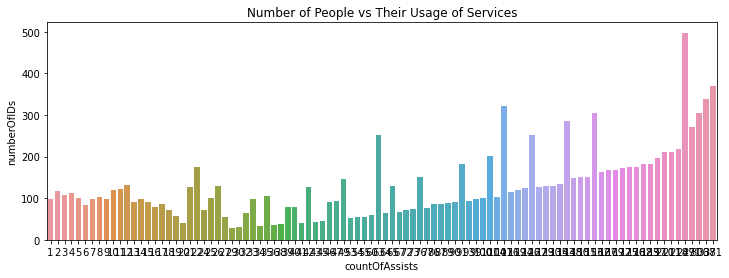

In [29]:
plt.figure(figsize=(12,4))
plt.title('Number of People vs Their Usage of Services')
plt.xticks([25,50,75,100,125,150,175,200])
chart=sns.barplot(x=care_count_df.index,y='numberOfIDs',data=care_count_df)
#chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


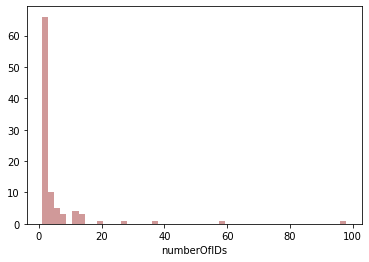

In [ ]:
sns.distplot(care_count_df['numberOfIDs'],kde=False,color='darkred')

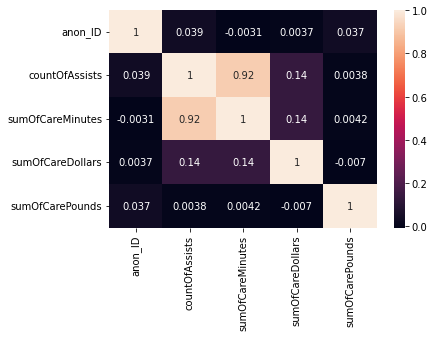

In [ ]:
sns.heatmap(caremgt.corr(),annot=True)

In [ ]:
caremgt.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
anon_ID,490.0,319.687755,187.13231,1.0,155.25,321.0,485.75,641.0
careDuration,490,271 days 19:41:23.265306124,322 days 23:16:03.024215932,0 days 00:00:00,1 days 00:00:00,106 days 12:00:00,495 days 06:00:00,981 days 00:00:00
countOfAssists,490.0,25.483673,50.238091,1.0,2.0,6.0,21.0,371.0
sumOfCareMinutes,490.0,187.966837,410.364049,1.0,13.0,40.5,131.25,4321.0
sumOfCareDollars,490.0,0.030612,0.280741,0.0,0.0,0.0,0.0,5.0
sumOfCarePounds,490.0,0.102041,1.595557,0.0,0.0,0.0,0.0,25.0


After flatten, what joins make sense?

In [ ]:
caremgt.to_csv('/content/gdrive/MyDrive/dataPhilly_ElderNet/caremgt_flat.csv')